# Neural and Universal Ordinary Differential Equations: Part 01
Following along from notes by [Chris Rackauckas](https://mitmath.github.io/18S096SciML/lecture3/diffeq_ml).

We can relate neural networks to differential equations through the *neural differential equations*. To begin, consider the recurrent neural network:

$$x_{n+1} = x_n + \text{NN}(x_n).$$

In general, we can consider pulling out a multiplication factor $h$, such that $t_{n+1} = t_n + h$, and

$$x_{n+1} = x_n + h \cdot\text{NN}(x_n),$$

$$\frac{x_{n+1} - x_n}{h} = \text{NN}(x_n),$$

allowing us to rewrite the limit $h \rightarrow 0$

$$x^\prime = \text{NN}(x_n).$$

## Training ODEs
Rackauckas has written exstensive notes on [training neural ODEs](https://mitmath.github.io/18337/lecture11/adjoints), which I will summarize in my own words here (todo). 

For simplicity, we will not concern ourselves with the details here, and instead use the default gradient calculation in `DiffEqFlux.jl`.

We will use the [`Flux.jl`](https://github.com/FluxML/Flux.jl) neural network library. Let us fist define a problem, namely the [Lotka-Volterra system](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations):

In [1]:
using OrdinaryDiffEq, Plots, Flux, DiffEqFlux, Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7957390355640577764\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13871915961296633912\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7957390355640577764\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
function lotka_volterra!(du, u, p, t)
    x, y = u
    α, β, δ, γ = p
    du[1] = α * x - β * x * y
    du[2] = - δ * y + γ * x * y
end

lotka_volterra! (generic function with 1 method)

Next, we solve this using a traditional ODEProblem approach:

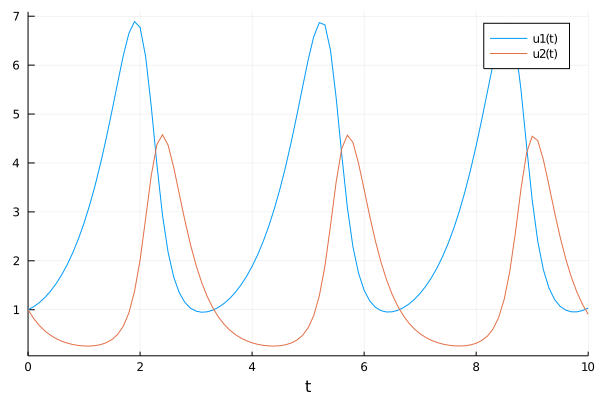

In [3]:
u0 = [1.0, 1.0]
tspan = (0.0, 10.0)

p = [1.5, 1.0, 3.0, 1.0]

prob = ODEProblem(lotka_volterra!, u0, tspan, p)
sol = solve(prob, Tsit5(), saveat=0.1)

plot(sol)

### Building a neural network

Next, we define a *single layer* NN, that uses `concrete_solve` to return a $x(t)$ solution. The method `concrete_solve` is built on `DifferentialEquations.jl`'s `solve` method, which uses a backpropagation algorithm to determine the gradient:

In [4]:
test_data = Array(sol)
p2 = [2.2, 1.0, 2.0, 0.4] # inital parameter vector

function predict_adjoint() # single layer neural network
    Array(
        concrete_solve(
            prob, 
            Tsit5(), 
            u0,
            p2,
            saveat=0.1, 
            abstol=1e-6,
            reltol=1e-5
        )
    )
end

predict_adjoint (generic function with 1 method)

Next we specify a loss function through which we can evaluate the model. Our aim is to ensure the Lotka-Volterra solution is a constant $x(t)=1$, so will define the loss as the distance from 1:

In [5]:
loss_adjoint() = sum(abs2, predict_adjoint() - test_data)

loss_adjoint (generic function with 1 method)

### Training the network
We will use ADAM optimization, with a callback to observe the training steps:

In [14]:
training_plots = []
iter = 0

function callback()
    global iter += 1
    if iter % 50 == 0
        @show loss_adjoint()

        # use remake to reconstruct problem with updated parameters
        pl = plot(
            solve(
                remake(
                    prob,
                    p=p2
                ),
                Tsit5(),
                saveat=0.0:0.1:10.0
            ),
            ylim=(0,8)
        )

        Plots.scatter!(
            pl, 
            0.0:0.1:10,
            test_data',
            markersize=2
        )

        push!(training_plots, pl)
    end
end

# ode with initial parameter values
callback()

data = Iterators.repeated((), 300) # 300 training cycles

# configure optimizer
opt = ADAM(0.1)

# train model
Flux.train!(loss_adjoint, Flux.params(p2), data, opt, cb=callback)
"Done"

loss_adjoint() = 0.2425901898013634
loss_adjoint() = 0.01042704120662278
loss_adjoint() = 0.003199772005970147
loss_adjoint() = 0.0030870894115670026
loss_adjoint() = 0.0030869582137027095
loss_adjoint() = 0.003086960089165609


"Done"

We can continue along this line by using gradient descent to force a monotone functional convergence:

In [15]:
data = Iterators.repeated((), 300)

opt = Descent(0.00001)
Flux.train!(loss_adjoint, Flux.params(p), data, opt, cb=callback)
"Done"

loss_adjoint() = 0.0030869600935169413
loss_adjoint() = 0.0030869600935169413
loss_adjoint() = 0.0030869600935169413
loss_adjoint() = 0.0030869600935169413
loss_adjoint() = 0.0030869600935169413
loss_adjoint() = 0.0030869600935169413


"Done"

In [16]:
# using interactive widget
@manipulate for i in 1:length(training_plots)
    plot(training_plots[i])
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 12,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
6, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/aelfric/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/aelfric/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/aelfric/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/home/aelfric/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/home/aelfric/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f435c458eb0, Task (runnable) @0x00007f435c458eb0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"1402828636011870350\",\"id\":\"14931718865398621503\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"nam